# Setup

In [ ]:
import os, pickle, copy, itertools
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [ ]:
root = './'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/ContextualBiasStacking/decision_tree

/content/drive/MyDrive/ContextualBiasStacking/decision_tree


In [ ]:
def combine_models(dir_name: str, labels=False):
  result = None
  # validation: 0: featuresplit 1: standard 2: weighted
  # test: 0: standard 1: weighted
  for i, pkl_file in enumerate(sorted(os.listdir(dir_name))):
    print(pkl_file)
    features = pickle.load(open('{}/{}'.format(dir_name, pkl_file), 'rb'))
    if labels:
      result = features
    else: 
      features = np.expand_dims(features, axis=1) # get the M axis
      if i==0:
        result = features
      else:
        result = np.concatenate((result, features), axis=1)
    
  print('{} shape: {}'.format(dir_name, result.shape))
  return result

In [ ]:
# train_meta = combine_models('train_meta')
val_meta = combine_models(root+'val_meta')
test_meta = combine_models(root+'test_meta')

featuresplit_val_meta.pkl
standard_val_meta.pkl
weighted_val_meta.pkl
./val_meta shape: (16557, 3, 171)
standard_test_meta.pkl
weighted_test_meta.pkl
./test_meta shape: (40504, 2, 171)


In [ ]:
dir_name = root+'labels_list'
# labels_list_train = pickle.load(open('{}/{}'.format(dir_name, 'labels_list_80.pkl'), 'rb'))
labels_list_val = pickle.load(open('{}/{}'.format(dir_name, 'label_list_val.pkl'), 'rb'))
labels_list_test = pickle.load(open('{}/{}'.format(dir_name, 'label_list_test.pkl'), 'rb'))
# print('labels_list_train shape:', labels_list_train.shape)
print('labels_list_val shape:', labels_list_val.shape)
print('labels_list_test shape:', labels_list_test.shape)

labels_list_val shape: (16557, 171)
labels_list_test shape: (40504, 171)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class Dataset(Dataset):
    def __init__(self, meta_features, img_labels_list):
        # self.meta_features = meta_features > 0.5
        self.meta_features = meta_features 
        self.img_labels_list = img_labels_list

    def __len__(self):
        return self.img_labels_list.shape[0]

    def __getitem__(self, index):
        X = self.meta_features[index]
        y = self.img_labels_list[index]
        return X, y

In [ ]:
val_dset = Dataset(val_meta, labels_list_val)
val_bs = val_meta.shape[0]
val_loader = DataLoader(val_dset, batch_size=val_bs, shuffle=False, num_workers=1)

test_dset = Dataset(test_meta, labels_list_test)
test_bs = test_meta.shape[0]
test_loader = DataLoader(test_dset, batch_size=test_bs, shuffle=False, num_workers=1)

In [ ]:
biased_classes_mapped = pickle.load(open('../biased_classes_mapped.pkl', 'rb'))
humanlabels_to_onehot = pickle.load(open('../humanlabels_to_onehot.pkl', 'rb'))
unbiased_classes_mapped = pickle.load(open('../unbiased_classes_mapped.pkl', 'rb'))

onehot_to_humanlabels = dict((y,x) for x,y in humanlabels_to_onehot.items())
biased_classes_list = list(biased_classes_mapped.keys())

# Gather scores on the validation or the test set

In [ ]:
split = 'validation'

In [ ]:
if split == 'validation': loader = val_loader
elif split == 'test': loader = test_loader

In [ ]:
# Grab scores and labels (just need 1 loop because our batch size equals numsamples)
for _, (scores, labels) in enumerate(loader):
    scores = scores.numpy()
    labels = labels.numpy()

In [ ]:
# Assign the scores to the correct models
if split == 'validation':
    fs_scores = scores[:, 0, :]
    standard_scores = scores[:, 1, :]
    weighted_scores = scores[:, 2, :]
else:
    standard_scores = scores[:, 0, :]
    weighted_scores = scores[:, 1, :]

In [ ]:
nclasses = 171
nsamples = scores.shape[0]

# Calculate mAP with the scores

In [ ]:
# final scores: probability scores (in decision rule algorithm, some rows have been replaces by the weighted model's results)
def calculate_results(name, final_scores):

    # Calculate mAP of all categories or the 60 non-biased categories
    APs = []
    for k in range(171):
        APs.append(average_precision_score(labels[:,k], final_scores[:,k]))
    mAP = np.nanmean(APs)
    mAP_nonbiased = np.nanmean([APs[i] for i in unbiased_classes_mapped])
    
    # Calculate exclusive/co-occur AP for each of the 20 biased categories                                                                                              
    exclusive_AP_list = []
    cooccur_AP_list = []
    biased_classes_list = list(biased_classes_mapped.keys())

    for k in range(len(biased_classes_list)):
        b = biased_classes_list[k]
        c = biased_classes_mapped[b]

        # Categorize the images into co-occur/exclusive/other                                                                                                  
        cooccur = (labels[:,b]==1) & (labels[:,c]==1)
        exclusive = (labels[:,b]==1) & (labels[:,c]==0)
        other = (~exclusive) & (~cooccur)

        cooccur_AP = average_precision_score(labels[cooccur+other, b], final_scores[cooccur+other, b])
        exclusive_AP = average_precision_score(labels[exclusive+other, b], final_scores[exclusive+other, b])
        cooccur_AP_list.append(cooccur_AP)
        exclusive_AP_list.append(exclusive_AP)
    
    print('{}: all - {:.1f}, nonbiased - {:.1f}, exclusive - {:.1f}, cooccur - {:.1f}'.format(name, mAP*100, mAP_nonbiased*100, 
                                                      np.mean(exclusive_AP_list)*100, 
                                                      np.mean(cooccur_AP_list)*100))
    
    return mAP*100, mAP_nonbiased*100, np.mean(exclusive_AP_list)*100, np.mean(cooccur_AP_list)*100


In [ ]:
print('All, Non-biased, Exclusive, Co-occur\n')

name = 'standard'
final_scores = copy.deepcopy(standard_scores)
calculate_results(name, final_scores)

name = 'weighted'
final_scores = copy.deepcopy(weighted_scores)
calculate_results(name, final_scores)

if split == 'validation':
    name = 'featuresplit'
    final_scores = copy.deepcopy(fs_scores)
    calculate_results(name, final_scores)
    
name = 'average'
final_scores = copy.deepcopy((standard_scores+weighted_scores)/2)
calculate_results(name, final_scores)

name = 'max'
final_scores = copy.deepcopy(np.maximum(standard_scores, weighted_scores))
calculate_results(name, final_scores)

weight = 0.3
name = '{}*standard + {}*weighted'.format(weight, 1-weight)
final_scores = copy.deepcopy(weight*standard_scores + (1-weight)*weighted_scores)
calculate_results(name, final_scores)

All, Non-biased, Exclusive, Co-occur

standard: all - 55.0, nonbiased - 72.1, exclusive - 20.7, cooccur - 65.2
weighted: all - 54.5, nonbiased - 71.7, exclusive - 24.4, cooccur - 60.0
featuresplit: all - 54.9, nonbiased - 71.9, exclusive - 22.4, cooccur - 64.5
average: all - 54.9, nonbiased - 72.0, exclusive - 22.4, cooccur - 63.2
max: all - 54.8, nonbiased - 72.0, exclusive - 24.2, cooccur - 60.6
0.3*standard + 0.7*weighted: all - 54.8, nonbiased - 71.9, exclusive - 23.1, cooccur - 62.2


(54.79808062882034, 71.94267206773442, 23.114459263079823, 62.1717407355631)

In [ ]:
# Decide which score to used based on the ground-truth label

# Initialize with standard scores
final_scores = copy.deepcopy(standard_scores)

# Loop over each of the 20 biased category pairs
for k in range(len(biased_classes_list)):
    b = biased_classes_list[k]
    c = biased_classes_mapped[b]
    
    # Categorize the images into co-occur/exclusive/other                                                                                                  
    cooccur = (labels[:,b]==1) & (labels[:,c]==1)
    exclusive = (labels[:,b]==1) & (labels[:,c]==0)
    other = (~exclusive) & (~cooccur)
    
    # For exclusive images, replace standard scores with weighted scores
    for i in range(nsamples):
        if exclusive[i]: final_scores[i, b] = weighted_scores[i, b]
            
name = 'gt decision'
calculate_results(name, final_scores)

gt decision: all - 55.9, nonbiased - 72.1, exclusive - 38.8, cooccur - 65.2


(55.929030856635556, 72.06321580600526, 38.832704176720924, 65.23541753850736)

In [ ]:
# Decide which score to used based on the ground-truth label
amount_exclu = np.arange(0, 1, 0.01)
all_list, nonbiased_list, exclu_list, cooc_list = [], [], [], []
for amount_e in amount_exclu:
  print('amount_exclusive: ', amount_e)
  # Initialize with standard scores
  final_scores = copy.deepcopy(standard_scores)

  # Loop over each of the 20 biased category pairs
  count = 0
  for k in range(len(biased_classes_list)):
      b = biased_classes_list[k]
      c = biased_classes_mapped[b]
      
      # Categorize the images into co-occur/exclusive/other                                                                                                  
      cooccur = (labels[:,b]==1) & (labels[:,c]==1)
      exclusive = (labels[:,b]==1) & (labels[:,c]==0)
      other = (~exclusive) & (~cooccur)
      # For exclusive images, replace standard scores with weighted scores
      for i in range(nsamples):
          if exclusive[i]: 
              # prob of recording this exclusive example
              s = np.random.binomial(1, amount_e, 1)
              if s[0]==True:
                final_scores[i, b] = weighted_scores[i, b]              
  name = 'gt decision'
  all, nonbiased, exclu, cooc = calculate_results(name, final_scores)
  all_list.append(all)
  nonbiased_list.append(nonbiased)
  exclu_list.append(exclu)
  cooc_list.append(cooc)

amount_exclusive:  0.0
gt decision: all - 55.0, nonbiased - 72.1, exclusive - 20.7, cooccur - 65.2
amount_exclusive:  0.01
gt decision: all - 55.0, nonbiased - 72.1, exclusive - 20.8, cooccur - 65.2
amount_exclusive:  0.02
gt decision: all - 55.0, nonbiased - 72.1, exclusive - 21.0, cooccur - 65.2
amount_exclusive:  0.03
gt decision: all - 55.0, nonbiased - 72.1, exclusive - 21.2, cooccur - 65.2
amount_exclusive:  0.04
gt decision: all - 55.0, nonbiased - 72.1, exclusive - 21.3, cooccur - 65.2
amount_exclusive:  0.05
gt decision: all - 55.1, nonbiased - 72.1, exclusive - 21.5, cooccur - 65.2
amount_exclusive:  0.06
gt decision: all - 55.1, nonbiased - 72.1, exclusive - 22.3, cooccur - 65.2
amount_exclusive:  0.07
gt decision: all - 55.1, nonbiased - 72.1, exclusive - 21.7, cooccur - 65.2
amount_exclusive:  0.08
gt decision: all - 55.1, nonbiased - 72.1, exclusive - 21.8, cooccur - 65.2
amount_exclusive:  0.09
gt decision: all - 55.1, nonbiased - 72.1, exclusive - 22.6, cooccur - 65.2
a

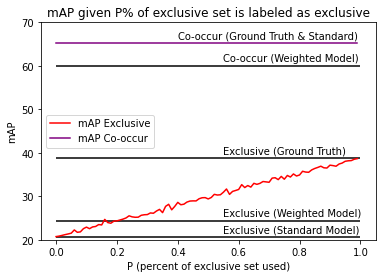

In [ ]:
i=0
#plt.plot(amount_exclu[i:], all_list[i:], label='mAP All')
#plt.plot(amount_exclu[i:], nonbiased_list[i:], label='mAP Unbiased')
plt.plot(amount_exclu[i:], exclu_list[i:], label='mAP Exclusive', color='red')
plt.plot(amount_exclu[i:], cooc_list[i:], label='mAP Co-occur', color='purple')
plt.xlabel("P (percent of exclusive set used)")
plt.ylabel('mAP')
plt.legend(loc='center left')
plt.ylim([20, 70])
plt.title('mAP given P% of exclusive set is labeled as exclusive')
#plt.hlines(65.2, 0, 1)
plt.text(0.40, 66.2, "Co-occur (Ground Truth & Standard)")

plt.hlines(24.4, 0, 1)
plt.text(0.55, 25.4, "Exclusive (Weighted Model)")

plt.hlines(38.8, 0, 1)
plt.text(0.55, 39.8, "Exclusive (Ground Truth)")

plt.hlines(20.7, 0, 1)
plt.text(0.55, 21.7, "Exclusive (Standard Model)")

plt.hlines(60.0, 0, 1)
plt.text(0.55, 61.0, "Co-occur (Weighted Model)")
plt.show()


In [ ]:
def decision_rule(name='decision rule (standard): ', decision_scores=standard_scores, alpha_min=0, alpha_max=1):
  # Decide which score to used based on the ground-truth label

  # Initialize with standard scores
  alphas = np.arange(alpha_min, alpha_max, 0.01)
  mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = [], [], [], []

  for alpha in alphas:
    print('alpha: ', alpha)
    final_scores = copy.deepcopy(standard_scores) #fixed 
    name = name

    # Loop over each of the 20 biased category pairs
    for k in range(len(biased_classes_list)):
        b = biased_classes_list[k]
        c = biased_classes_mapped[b]
        
        # Categorize the images into co-occur/exclusive/other        
        #cooccur = (decision_scores[:,b]>alpha) & (decision_scores[:,c] > alpha)
        # exclusive = ((weighted_scores[:,b])+ (1-standard_scores[:,c])) > alpha
        exclusive = (decision_scores[:,b]>alpha) & (decision_scores[:,c] < 1-alpha)
        #other = (~exclusive) & (~cooccur)
        
        # For exclusive images, replace standard scores with weighted scores
        for i in range(nsamples):
            if exclusive[i]: final_scores[i, b] = weighted_scores[i, b]
                

    all, unbiased, excl, co = calculate_results(name, final_scores)
    mAP_all.append(all)
    mAP_unbiased_all.append(unbiased)
    mAP_exclusive_all.append(excl)
    mAP_cooccur_all.append(co)
  return mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all


alpha:  0.0
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  0.01
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.2
alpha:  0.02
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.2
alpha:  0.03
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.2
alpha:  0.04
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.3
alpha:  0.05
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.4
alpha:  0.06
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.5
alpha:  0.07
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.5
alpha:  0.08
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.6
alpha:  0.09
decision rule (standard): : all - 54.8, nonbiased - 

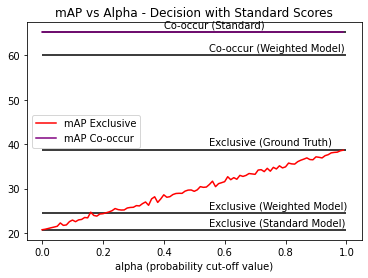

In [ ]:
mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = decision_rule(decision_scores=standard_scores)

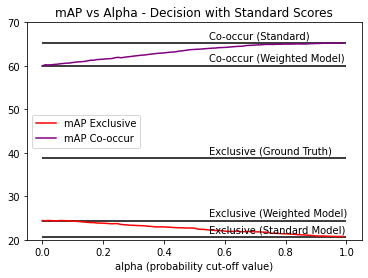

In [ ]:
i=0
#plt.plot(amount_exclu[i:], all_list[i:], label='mAP All')
#plt.plot(amount_exclu[i:], nonbiased_list[i:], label='mAP Unbiased')
plt.plot(amount_exclu[i:], mAP_exclusive_all[i:], label='mAP Exclusive', color='red')
plt.plot(amount_exclu[i:], mAP_cooccur_all[i:], label='mAP Co-occur', color='purple')
plt.legend(loc='center left')
plt.ylim([20, 70])
plt.xlabel("alpha (probability cut-off value)")
plt.legend(loc='center left')
plt.title('mAP vs Alpha - Decision with Standard Scores')
plt.hlines(65.2, 0, 1)
plt.text(0.55, 66.2, "Co-occur (Standard)")

plt.hlines(24.4, 0, 1)
plt.text(0.55, 25.4, "Exclusive (Weighted Model)")

plt.hlines(38.8, 0, 1)
plt.text(0.55, 39.8, "Exclusive (Ground Truth)")

plt.hlines(20.7, 0, 1)
plt.text(0.55, 21.7, "Exclusive (Standard Model)")

plt.hlines(60.0, 0, 1)
plt.text(0.55, 61.0, "Co-occur (Weighted Model)")
plt.show()

In [ ]:
mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = decision_rule(decision_scores=weighted_scores, alpha_max=0.7, alpha_min=0.6)

alpha:  0.6
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 23.7, cooccur - 60.8
alpha:  0.61
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 23.7, cooccur - 60.8
alpha:  0.62
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 23.7, cooccur - 60.9
alpha:  0.63
decision rule (standard): : all - 54.8, nonbiased - 72.1, exclusive - 23.7, cooccur - 61.0
alpha:  0.64
decision rule (standard): : all - 54.9, nonbiased - 72.1, exclusive - 23.6, cooccur - 61.1
alpha:  0.65
decision rule (standard): : all - 54.9, nonbiased - 72.1, exclusive - 23.4, cooccur - 61.3
alpha:  0.66
decision rule (standard): : all - 54.9, nonbiased - 72.1, exclusive - 23.4, cooccur - 61.4
alpha:  0.67
decision rule (standard): : all - 54.9, nonbiased - 72.1, exclusive - 23.4, cooccur - 61.5
alpha:  0.68
decision rule (standard): : all - 54.9, nonbiased - 72.1, exclusive - 23.4, cooccur - 61.6
alpha:  0.6900000000000001
decision rule (standard): : all - 54.9

In [ ]:
mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = decision_rule(decision_scores=standard_scores)
i=0
plt.plot(np.arange(0, 1, 0.01)[i:], mAP_all[i:], label='mAP All')
plt.plot(np.arange(0, 1, 0.01)[i:], mAP_unbiased_all[i:], label='mAP Unbiased')
plt.plot(np.arange(0, 1, 0.01)[i:], mAP_exclusive_all[i:], label='mAP Exclusive')
plt.plot(np.arange(0, 1, 0.01)[i:], mAP_cooccur_all[i:], label='mAP Co-occur')
plt.xlabel("alpha (probability cut-off value)")
plt.legend(loc='center left')
plt.title('mAP vs Alpha - Decision with Standard Prob')
plt.hlines(65.2, 0, 1)
plt.text(0.40, 66.2, "Co-occur (Standard)")

plt.hlines(24.4, 0, 1)
plt.text(0.55, 25.4, "Exclusive (Weighted Model)")

plt.hlines(38.8, 0, 1)
plt.text(0.55, 39.8, "Exclusive (Ground Truth)")

plt.hlines(20.7, 0, 1)
plt.text(0.55, 21.7, "Exclusive (Standard Model)")

plt.hlines(60.0, 0, 1)
plt.text(0.55, 61.0, "Co-occur (Weighted Model)")
plt.show()


alpha:  0.3


NameError: ignored

alpha:  0.0
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  0.01
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.1
alpha:  0.02
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.5, cooccur - 60.1
alpha:  0.03
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.6, cooccur - 60.0
alpha:  0.04
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.5, cooccur - 59.9
alpha:  0.05
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.6, cooccur - 59.8
alpha:  0.06
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.7, cooccur - 59.7
alpha:  0.07
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.7, cooccur - 59.7
alpha:  0.08
decision rule (weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.6, cooccur - 59.7
alpha:  0.09
decision rule (weighted): : all - 54.8, nonbiased - 

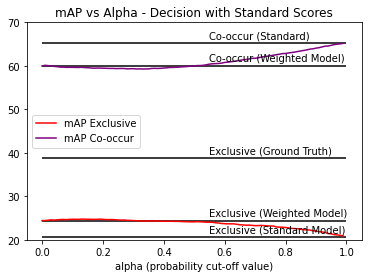

In [ ]:
mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = decision_rule(name='decision rule (weighted): ', 
                                                                              decision_scores=weighted_scores)
#plt.plot(amount_exclu[i:], all_list[i:], label='mAP All')
#plt.plot(amount_exclu[i:], nonbiased_list[i:], label='mAP Unbiased')
plt.plot(amount_exclu[i:], mAP_exclusive_all[i:], label='mAP Exclusive', color='red')
plt.plot(amount_exclu[i:], mAP_cooccur_all[i:], label='mAP Co-occur', color='purple')

plt.legend(loc='center left')
plt.ylim([20, 70])
plt.xlabel("alpha (probability cut-off value)")
plt.legend(loc='center left')
plt.title('mAP vs Alpha - Decision with Standard Scores')
plt.hlines(65.2, 0, 1)
plt.text(0.55, 66.2, "Co-occur (Standard)")

plt.hlines(24.4, 0, 1)
plt.text(0.55, 25.4, "Exclusive (Weighted Model)")

plt.hlines(38.8, 0, 1)
plt.text(0.55, 39.8, "Exclusive (Ground Truth)")

plt.hlines(20.7, 0, 1)
plt.text(0.55, 21.7, "Exclusive (Standard Model)")

plt.hlines(60.0, 0, 1)
plt.text(0.55, 61.0, "Co-occur (Weighted Model)")
plt.show()


alpha:  -1.0
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.99
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.98
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.97
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.96
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.95
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.94
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.9299999999999999
decision rule (standard-weighted): : all - 54.8, nonbiased - 72.1, exclusive - 24.4, cooccur - 60.0
alpha:  -0.9199999999999999
decision rule (standard-weighted): : all - 54.8

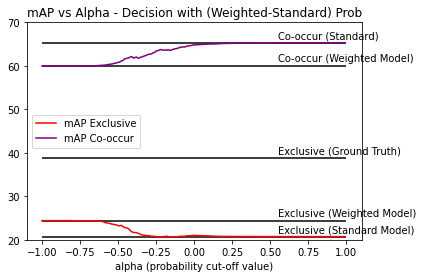

In [ ]:
mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = decision_rule(name='decision rule (standard-weighted): ', 
                                                                              decision_scores=standard_scores - weighted_scores, 
                                                                              alpha_min=-1, alpha_max=1)
#plt.plot(np.arange(-1, 1, 0.01)[i:], mAP_all[i:], label='mAP All')
#plt.plot(np.arange(-1, 1, 0.01)[i:], mAP_unbiased_all[i:], label='mAP Unbiased')
plt.plot(np.arange(-1, 1, 0.01), mAP_exclusive_all, label='mAP Exclusive', color='red')
plt.plot(np.arange(-1, 1, 0.01), mAP_cooccur_all, label='mAP Co-occur', color='purple')
plt.xlabel("alpha (probability cut-off value)")
plt.ylim([20, 70])
plt.legend(loc='center left')
plt.title('mAP vs Alpha - Decision with (Weighted-Standard) Prob')

plt.hlines(65.2, -1, 1)
plt.text(0.55, 66.2, "Co-occur (Standard)")

plt.hlines(24.4, -1, 1)
plt.text(0.55, 25.4, "Exclusive (Weighted Model)")

plt.hlines(38.8, -1, 1)
plt.text(0.55, 39.8, "Exclusive (Ground Truth)")

plt.hlines(20.7, -1, 1)
plt.text(0.55, 21.7, "Exclusive (Standard Model)")

plt.hlines(60.0, -1, 1)
plt.text(0.55, 61.0, "Co-occur (Weighted Model)")
plt.show()



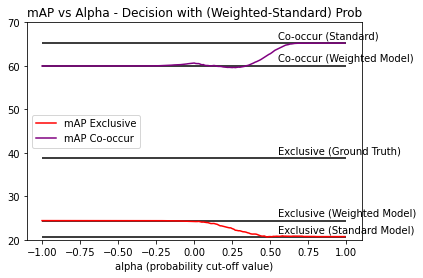

In [ ]:
#mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = decision_rule(name='decision rule (weighted - standard): ', 
                                                                              #decision_scores= weighted_scores - standard_scores, 
                                                                              #alpha_min=-1, alpha_max=1)
#plt.plot(np.arange(-1, 1, 0.01)[i:], mAP_all[i:], label='mAP All')
#plt.plot(np.arange(-1, 1, 0.01)[i:], mAP_unbiased_all[i:], label='mAP Unbiased')
plt.plot(np.arange(-1, 1, 0.01), mAP_exclusive_all, label='mAP Exclusive', color='red')
plt.plot(np.arange(-1, 1, 0.01), mAP_cooccur_all, label='mAP Co-occur', color='purple')
plt.xlabel("alpha (probability cut-off value)")
plt.ylim([20, 70])
plt.legend(loc='center left')
plt.title('mAP vs Alpha - Decision with (Weighted-Standard) Prob')

plt.hlines(65.2, -1, 1)
plt.text(0.55, 66.2, "Co-occur (Standard)")

plt.hlines(24.4, -1, 1)
plt.text(0.55, 25.4, "Exclusive (Weighted Model)")

plt.hlines(38.8, -1, 1)
plt.text(0.55, 39.8, "Exclusive (Ground Truth)")

plt.hlines(20.7, -1, 1)
plt.text(0.55, 21.7, "Exclusive (Standard Model)")

plt.hlines(60.0, -1, 1)
plt.text(0.55, 61.0, "Co-occur (Weighted Model)")
plt.show()


In [ ]:
def decision_rule_fpr(name='decision rule (standard): ', decision_scores=standard_scores, alpha_min=0, alpha_max=1):
  # Decide which score to used based on the ground-truth label

  # Initialize with standard scores
  alphas = np.arange(alpha_min, alpha_max, 0.01)
  tpr_all, fpr_all, precision_all, acc_all = [], [], [], []

  for alpha in alphas:
    print('alpha: ', alpha)
    tp_total, tn_total, fp_total, fn_total = 0, 0, 0, 0
    final_scores = copy.deepcopy(standard_scores) #fixed 
    name = name

    all_use_weighted_exclu = np.zeros(decision_scores.shape[0], dtype=bool)
    # Loop over each of the 20 biased category pairs
    for k in range(len(biased_classes_list)):
        b = biased_classes_list[k]
        c = biased_classes_mapped[b]
        
        # based on standard's probabilities and alpha, set boolean to use weighted
        use_weighted_exclu = (decision_scores[:, b] > alpha) & (decision_scores[:, c] < 1-alpha)
        # use_weighted_exclu = (scores_list[:, b] == 1) & (scores_list[:, c] == 0)
        all_use_weighted_exclu = all_use_weighted_exclu + use_weighted_exclu

        # check the accuracy of these subsets
        exclusive_label = (labels[:,b]==1) & (labels[:,c]==0)

        tp = np.sum(use_weighted_exclu & exclusive_label)
        tn = np.sum(~use_weighted_exclu & ~exclusive_label)
        fp = np.sum(use_weighted_exclu & ~exclusive_label)
        fn = np.sum(~use_weighted_exclu & exclusive_label)
        
        tp_total += tp
        tn_total += tn
        fp_total += fp
        fn_total += fn      

    tpr_all.append(tp_total/(tp_total+fn_total))
    fpr_all.append(fp_total/(fp_total+tn_total))
    precision_all.append((tp_total)/(tp_total+fp_total))
    acc_all.append((tp_total+tn_total)/(tp_total+tn_total+fp_total+fn_total))
  return tpr_all, fpr_all, precision_all, acc_all

In [ ]:
tpr_all, fpr_all, precision_all, acc_all = decision_rule_fpr(decision_scores=standard_scores)

alpha:  0.0
alpha:  0.01
alpha:  0.02
alpha:  0.03
alpha:  0.04
alpha:  0.05
alpha:  0.06
alpha:  0.07
alpha:  0.08
alpha:  0.09
alpha:  0.1
alpha:  0.11
alpha:  0.12
alpha:  0.13
alpha:  0.14
alpha:  0.15
alpha:  0.16
alpha:  0.17
alpha:  0.18
alpha:  0.19
alpha:  0.2
alpha:  0.21
alpha:  0.22
alpha:  0.23
alpha:  0.24
alpha:  0.25
alpha:  0.26
alpha:  0.27
alpha:  0.28
alpha:  0.29
alpha:  0.3
alpha:  0.31
alpha:  0.32
alpha:  0.33
alpha:  0.34
alpha:  0.35000000000000003
alpha:  0.36
alpha:  0.37
alpha:  0.38
alpha:  0.39
alpha:  0.4
alpha:  0.41000000000000003
alpha:  0.42
alpha:  0.43
alpha:  0.44
alpha:  0.45
alpha:  0.46
alpha:  0.47000000000000003
alpha:  0.48
alpha:  0.49
alpha:  0.5
alpha:  0.51
alpha:  0.52
alpha:  0.53
alpha:  0.54
alpha:  0.55
alpha:  0.56
alpha:  0.5700000000000001
alpha:  0.58
alpha:  0.59
alpha:  0.6
alpha:  0.61
alpha:  0.62
alpha:  0.63
alpha:  0.64
alpha:  0.65
alpha:  0.66
alpha:  0.67
alpha:  0.68
alpha:  0.6900000000000001
alpha:  0.70000000000000

alpha:  0.0
alpha:  0.01
alpha:  0.02
alpha:  0.03
alpha:  0.04
alpha:  0.05
alpha:  0.06
alpha:  0.07
alpha:  0.08
alpha:  0.09
alpha:  0.1
alpha:  0.11
alpha:  0.12
alpha:  0.13
alpha:  0.14
alpha:  0.15
alpha:  0.16
alpha:  0.17
alpha:  0.18
alpha:  0.19
alpha:  0.2
alpha:  0.21
alpha:  0.22
alpha:  0.23
alpha:  0.24
alpha:  0.25
alpha:  0.26
alpha:  0.27
alpha:  0.28
alpha:  0.29
alpha:  0.3
alpha:  0.31
alpha:  0.32
alpha:  0.33
alpha:  0.34
alpha:  0.35000000000000003
alpha:  0.36
alpha:  0.37
alpha:  0.38
alpha:  0.39
alpha:  0.4
alpha:  0.41000000000000003
alpha:  0.42
alpha:  0.43
alpha:  0.44
alpha:  0.45
alpha:  0.46
alpha:  0.47000000000000003
alpha:  0.48
alpha:  0.49
alpha:  0.5
alpha:  0.51
alpha:  0.52
alpha:  0.53
alpha:  0.54
alpha:  0.55
alpha:  0.56
alpha:  0.5700000000000001
alpha:  0.58
alpha:  0.59
alpha:  0.6
alpha:  0.61
alpha:  0.62
alpha:  0.63
alpha:  0.64
alpha:  0.65
alpha:  0.66
alpha:  0.67
alpha:  0.68
alpha:  0.6900000000000001
alpha:  0.70000000000000

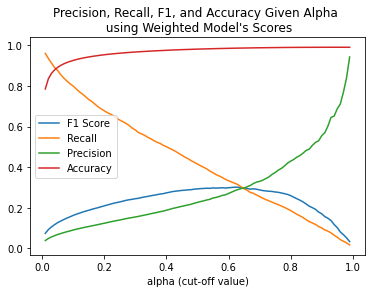

In [ ]:
tpr_all, fpr_all, precision_all, acc_all = decision_rule_fpr(decision_scores=weighted_scores)
f1_all = (2 * np.multiply(precision_all, tpr_all)) / (np.add(precision_all,tpr_all))
plt.plot(np.arange(0, 1, 0.01)[1:], f1_all[1:], label='F1 Score')
plt.plot(np.arange(0, 1, 0.01)[1:], tpr_all[1:], label='Recall')
plt.plot(np.arange(0, 1, 0.01)[1:], precision_all[1:], label='Precision')
plt.plot(np.arange(0, 1, 0.01)[1:], acc_all[1:], label='Accuracy')
plt.xlabel("alpha (cut-off value)")
plt.legend()
plt.title("Precision, Recall, F1, and Accuracy Given Alpha \n using Weighted Model's Scores")
plt.show()

alpha:  -1.0
alpha:  -0.99
alpha:  -0.98
alpha:  -0.97
alpha:  -0.96
alpha:  -0.95
alpha:  -0.94
alpha:  -0.9299999999999999
alpha:  -0.9199999999999999
alpha:  -0.9099999999999999
alpha:  -0.8999999999999999
alpha:  -0.8899999999999999
alpha:  -0.8799999999999999
alpha:  -0.8699999999999999
alpha:  -0.8599999999999999
alpha:  -0.8499999999999999
alpha:  -0.8399999999999999
alpha:  -0.8299999999999998
alpha:  -0.8199999999999998
alpha:  -0.8099999999999998
alpha:  -0.7999999999999998
alpha:  -0.7899999999999998
alpha:  -0.7799999999999998
alpha:  -0.7699999999999998
alpha:  -0.7599999999999998
alpha:  -0.7499999999999998
alpha:  -0.7399999999999998
alpha:  -0.7299999999999998
alpha:  -0.7199999999999998
alpha:  -0.7099999999999997
alpha:  -0.6999999999999997
alpha:  -0.6899999999999997
alpha:  -0.6799999999999997
alpha:  -0.6699999999999997
alpha:  -0.6599999999999997
alpha:  -0.6499999999999997
alpha:  -0.6399999999999997
alpha:  -0.6299999999999997
alpha:  -0.6199999999999997
alpha: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


alpha:  0.5100000000000013
alpha:  0.5200000000000014
alpha:  0.5300000000000014
alpha:  0.5400000000000014
alpha:  0.5500000000000014
alpha:  0.5600000000000014
alpha:  0.5700000000000014
alpha:  0.5800000000000014
alpha:  0.5900000000000014
alpha:  0.6000000000000014
alpha:  0.6100000000000014
alpha:  0.6200000000000014
alpha:  0.6300000000000014
alpha:  0.6400000000000015
alpha:  0.6500000000000015
alpha:  0.6600000000000015
alpha:  0.6700000000000015
alpha:  0.6800000000000015
alpha:  0.6900000000000015
alpha:  0.7000000000000015
alpha:  0.7100000000000015
alpha:  0.7200000000000015
alpha:  0.7300000000000015
alpha:  0.7400000000000015
alpha:  0.7500000000000016
alpha:  0.7600000000000016
alpha:  0.7700000000000016
alpha:  0.7800000000000016
alpha:  0.7900000000000016
alpha:  0.8000000000000016
alpha:  0.8100000000000016
alpha:  0.8200000000000016
alpha:  0.8300000000000016
alpha:  0.8400000000000016
alpha:  0.8500000000000016
alpha:  0.8600000000000017
alpha:  0.8700000000000017
a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


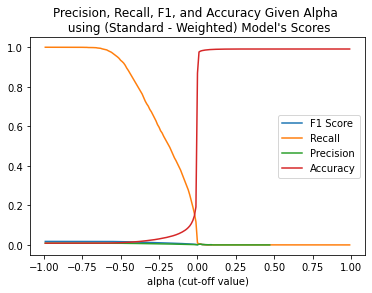

In [ ]:
tpr_all, fpr_all, precision_all, acc_all = decision_rule_fpr(decision_scores=standard_scores-weighted_scores, alpha_max=1, alpha_min=-1)
f1_all = (2 * np.multiply(precision_all, tpr_all)) / (np.add(precision_all,tpr_all))
plt.plot(np.arange(-1, 1, 0.01)[1:], f1_all[1:], label='F1 Score')
plt.plot(np.arange(-1, 1, 0.01)[1:], tpr_all[1:], label='Recall')
plt.plot(np.arange(-1, 1, 0.01)[1:], precision_all[1:], label='Precision')
plt.plot(np.arange(-1, 1, 0.01)[1:], acc_all[1:], label='Accuracy')
plt.xlabel("alpha (cut-off value)")
plt.legend()
plt.title("Precision, Recall, F1, and Accuracy Given Alpha \n using (Standard - Weighted) Model's Scores")
plt.show()

alpha:  -1.0
alpha:  -0.99
alpha:  -0.98
alpha:  -0.97
alpha:  -0.96
alpha:  -0.95
alpha:  -0.94
alpha:  -0.9299999999999999
alpha:  -0.9199999999999999
alpha:  -0.9099999999999999
alpha:  -0.8999999999999999
alpha:  -0.8899999999999999
alpha:  -0.8799999999999999
alpha:  -0.8699999999999999
alpha:  -0.8599999999999999
alpha:  -0.8499999999999999
alpha:  -0.8399999999999999
alpha:  -0.8299999999999998
alpha:  -0.8199999999999998
alpha:  -0.8099999999999998
alpha:  -0.7999999999999998
alpha:  -0.7899999999999998
alpha:  -0.7799999999999998
alpha:  -0.7699999999999998
alpha:  -0.7599999999999998
alpha:  -0.7499999999999998
alpha:  -0.7399999999999998
alpha:  -0.7299999999999998
alpha:  -0.7199999999999998
alpha:  -0.7099999999999997
alpha:  -0.6999999999999997
alpha:  -0.6899999999999997
alpha:  -0.6799999999999997
alpha:  -0.6699999999999997
alpha:  -0.6599999999999997
alpha:  -0.6499999999999997
alpha:  -0.6399999999999997
alpha:  -0.6299999999999997
alpha:  -0.6199999999999997
alpha: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


alpha:  0.8700000000000017
alpha:  0.8800000000000017
alpha:  0.8900000000000017
alpha:  0.9000000000000017
alpha:  0.9100000000000017
alpha:  0.9200000000000017
alpha:  0.9300000000000017
alpha:  0.9400000000000017
alpha:  0.9500000000000017
alpha:  0.9600000000000017
alpha:  0.9700000000000017
alpha:  0.9800000000000018
alpha:  0.9900000000000018


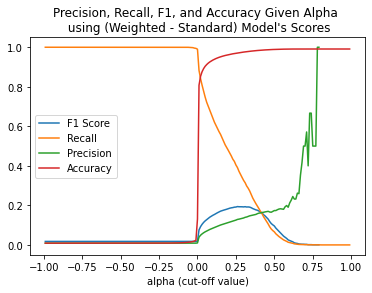

In [ ]:
tpr_all, fpr_all, precision_all, acc_all = decision_rule_fpr(decision_scores=weighted_scores- standard_scores, alpha_max=1, alpha_min=-1)
f1_all = (2 * np.multiply(precision_all, tpr_all)) / (np.add(precision_all,tpr_all))
plt.plot(np.arange(-1, 1, 0.01)[1:], f1_all[1:], label='F1 Score')
plt.plot(np.arange(-1, 1, 0.01)[1:], tpr_all[1:], label='Recall')
plt.plot(np.arange(-1, 1, 0.01)[1:], precision_all[1:], label='Precision')
plt.plot(np.arange(-1, 1, 0.01)[1:], acc_all[1:], label='Accuracy')
plt.xlabel("alpha (cut-off value)")
plt.legend()
plt.title("Precision, Recall, F1, and Accuracy Given Alpha \n using (Weighted - Standard) Model's Scores")
plt.show()

In [ ]:

f1_all = (2 * np.multiply(precision_all, tpr_all)) / (np.add(precision_all,tpr_all))
plt.plot(np.arange(0, 1, 0.01)[1:], f1_all[1:], label='F1 Score')
plt.plot(np.arange(0, 1, 0.01)[1:], tpr_all[1:], label='Recall')
plt.plot(np.arange(0, 1, 0.01)[1:], precision_all[1:], label='Precision')
plt.plot(np.arange(0, 1, 0.01)[1:], acc_all[1:], label='Accuracy')
plt.xlabel("alpha (cut-off value)")
plt.legend()
plt.title("Precision, Recall, F1, and Accuracy Given Alpha \n using Standard Model's Scores")
plt.show()

# Other code

In [ ]:
# Gather scores for cooccur/exclusive/other/b for all 20 biased categories
standard_cooccur_b, standard_cooccur_c = list(), list()
standard_exclusive_b, standard_exclusive_c = list(), list()
standard_other_b, standard_other_c = list(), list()
standard_b_class_b, standard_b_class_c = list(), list()
weighted_cooccur_b, weighted_cooccur_c = list(), list()
weighted_exclusive_b, weighted_exclusive_c = list(), list()
weighted_other_b, weighted_other_c = list(), list()
weighted_b_class_b, weighted_b_class_c = list(), list()

for k in range(len(biased_classes_list)):
    b = biased_classes_list[k]
    c = biased_classes_mapped[b]
    
    cooccur = (labels_list[:,b]==1) & (labels_list[:,c]==1)
    exclusive = (labels_list[:,b]==1) & (labels_list[:,c]==0)
    other = (~exclusive) & (~cooccur)
    b_class = (labels_list[:,b]==1)

    standard_cooccur_b.append(standard_scores_list[cooccur, b])
    standard_cooccur_c.append(standard_scores_list[cooccur, c])
    standard_exclusive_b.append(standard_scores_list[exclusive, b])
    standard_exclusive_c.append(standard_scores_list[exclusive, c])
    standard_other_b.append(standard_scores_list[other, b])
    standard_other_c.append(standard_scores_list[other, c])
    standard_b_class_b.append(standard_scores_list[b_class, b])
    standard_b_class_c.append(standard_scores_list[b_class, c])
    
    weighted_cooccur_b.append(weighted_scores_list[cooccur, b])
    weighted_cooccur_c.append(weighted_scores_list[cooccur, c])
    weighted_exclusive_b.append(weighted_scores_list[exclusive, b])
    weighted_exclusive_c.append(weighted_scores_list[exclusive, c])
    weighted_other_b.append(weighted_scores_list[other, b])
    weighted_other_c.append(weighted_scores_list[other, c])
    weighted_b_class_b.append(weighted_scores_list[b_class, b])
    weighted_b_class_c.append(weighted_scores_list[b_class, c])

standard_cooccur_b = list(itertools.chain.from_iterable(standard_cooccur_b))
standard_cooccur_c = list(itertools.chain.from_iterable(standard_cooccur_c))
standard_exclusive_b = list(itertools.chain.from_iterable(standard_exclusive_b))
standard_exclusive_c = list(itertools.chain.from_iterable(standard_exclusive_c))
standard_other_b = list(itertools.chain.from_iterable(standard_other_b))
standard_other_c = list(itertools.chain.from_iterable(standard_other_c))
standard_b_class_b = list(itertools.chain.from_iterable(standard_b_class_b))
standard_b_class_c = list(itertools.chain.from_iterable(standard_b_class_c))

weighted_cooccur_b = list(itertools.chain.from_iterable(weighted_cooccur_b))
weighted_cooccur_c = list(itertools.chain.from_iterable(weighted_cooccur_c))
weighted_exclusive_b = list(itertools.chain.from_iterable(weighted_exclusive_b))
weighted_exclusive_c = list(itertools.chain.from_iterable(weighted_exclusive_c))
weighted_other_b = list(itertools.chain.from_iterable(weighted_other_b))
weighted_other_c = list(itertools.chain.from_iterable(weighted_other_c))
weighted_b_class_b = list(itertools.chain.from_iterable(weighted_b_class_b))
weighted_b_class_c = list(itertools.chain.from_iterable(weighted_b_class_c))

In [ ]:
print('CO-OCCUR', len(standard_cooccur_b))
print('Standard: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(standard_cooccur_b), np.mean(standard_cooccur_c)))
print('Weighted: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(weighted_cooccur_b), np.mean(weighted_cooccur_c)))

print('\nEXCLUSIVE', len(standard_exclusive_b))
print('Standard: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(standard_exclusive_b), np.mean(standard_exclusive_c)))
print('Weighted: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(weighted_exclusive_b), np.mean(weighted_exclusive_c)))


print('\nOTHER', len(standard_other_b))
print('Standard: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(standard_other_b), np.mean(standard_other_c)))
print('Weighted: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(weighted_other_b), np.mean(weighted_other_c)))

print('\nB APPEARS', len(standard_b_class_b))
print('Standard: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(standard_b_class_b), np.mean(standard_b_class_c)))
print('Weighted: b score avg {:.4f}, c score avg {:.4f}'.format(np.mean(weighted_b_class_b), np.mean(weighted_b_class_c)))


In [ ]:
import matplotlib.pyplot as plt
def plot_hist(data, title, n_bins = 50):
    plt.hist(data, bins=n_bins)
    plt.title(title)
    plt.xlabel('Model Output' )
    plt.ylabel('Counts')
    return

In [ ]:
plt.figure(figsize=(24, 4))
plt.suptitle('Co-occur images')
plt.subplot(141)
plot_hist(standard_cooccur_b, 'Standard b scores')
plt.subplot(142)
plot_hist(standard_cooccur_c, 'Standard c scores')
plt.subplot(143)
plot_hist(weighted_cooccur_b, 'Weighted b scores')
plt.subplot(144)
plot_hist(weighted_cooccur_c, 'Weighted c scores')
plt.show()

In [ ]:
plt.figure(figsize=(24, 4))
plt.suptitle('Exclusive images')
plt.subplot(141)
plot_hist(standard_exclusive_b, 'Standard b scores')
plt.subplot(142)
plot_hist(standard_exclusive_c, 'Standard c scores')
plt.subplot(143)
plot_hist(weighted_exclusive_b, 'Weighted b scores')
plt.subplot(144)
plot_hist(weighted_exclusive_c, 'Weighted c scores')
plt.show()

In [ ]:
plt.figure(figsize=(24, 4))
plt.suptitle('Other images')
plt.subplot(141)
plot_hist(standard_other_b, 'Standard b scores')
plt.subplot(142)
plot_hist(standard_other_c, 'Standard c scores')
plt.subplot(143)
plot_hist(weighted_other_b, 'Weighted b scores')
plt.subplot(144)
plot_hist(weighted_other_c, 'Weighted c scores')
plt.show()

In [ ]:
plt.figure(figsize=(24, 4))
plt.suptitle('All images where b occurs')
plt.subplot(141)
plot_hist(standard_b_class_b, 'Standard b scores')
plt.subplot(142)
plot_hist(standard_b_class_c, 'Standard c scores')
plt.subplot(143)
plot_hist(weighted_b_class_b, 'Weighted b scores')
plt.subplot(144)
plot_hist(weighted_b_class_c, 'Weighted c scores')
plt.show()

In [ ]:
# DECISION MODEL
alphas = np.arange(0, 1, 0.1)
#alphas = [0.5]
mAP_all, mAP_unbiased_all, mAP_exclusive_all, mAP_cooccur_all = [], [], [], []
tpr_all, fpr_all, precision_all, acc_all = [], [], [], []
for alpha in alphas:
  print('alpha: ', alpha)
  tp_total, tn_total, fp_total, fn_total = 0, 0, 0, 0

  # one iteration through the val_loader because batch size = val data size
  for (X,y) in val_loader: 
    X = X.numpy() 
    # 0: featuresplit 1: standard 2: weighted
    standard_scores_list = X[:, 0, :]
    weighted_scores_list = X[:, 2, :]
    labels_list = y.numpy()
    decision_scores_list = labels_list
 
  # based on the scores of the standard model, create data_for_weighted and data_for_standard 
  # scores_list = standard_scores_list
  # scores_list = weighted_scores_list 
  # scores_list = (weighted_scores_list + standard_scores_list )/2
  scores_list = decision_scores_list

  all_use_weighted_exclu = np.zeros(scores_list.shape[0], dtype=bool)
  print(all_use_weighted_exclu.shape)
  for k in range(len(biased_classes_list)):
  #for k in range(1):
    b = biased_classes_list[k]
    c = biased_classes_mapped[b]
    
    # based on standard's probabilities and alpha, set boolean to use weighted
    use_weighted_exclu = (scores_list[:, b] > alpha) & (scores_list[:, c] < alpha)
    # use_weighted_exclu = (scores_list[:, b] == 1) & (scores_list[:, c] == 0)
    all_use_weighted_exclu = all_use_weighted_exclu + use_weighted_exclu

    # check the accuracy of these subsets
    exclusive_label = (labels_list[:,b]==1) & (labels_list[:,c]==0)

    tp = np.sum(use_weighted_exclu & exclusive_label)
    tn = np.sum(~use_weighted_exclu & ~exclusive_label)
    fp = np.sum(use_weighted_exclu & ~exclusive_label)
    fn = np.sum(~use_weighted_exclu & exclusive_label)
    
    tp_total += tp
    tn_total += tn
    fp_total += fp
    fn_total += fn

  # print(all_use_weighted_exclu.sum())

  # data_for_weighted: probabilities from exclusive data to feed into the weighted model
  data_for_weighted = weighted_scores_list[all_use_weighted_exclu]
  label_list_weighted = labels_list[all_use_weighted_exclu]

  # data_for_weighted: probabilities from non exclusive data to feed into the standard model
  data_for_standard = standard_scores_list[~all_use_weighted_exclu]
  label_list_standard = labels_list[~all_use_weighted_exclu]

  # combine data and label_list
  final_labels_list = np.concatenate((label_list_weighted, label_list_standard))
  final_scores_list = np.concatenate((data_for_weighted, data_for_standard))
  
  # calculate mAP
  APs = []
  for k in range(n_classes):
    APs.append(average_precision_score(final_labels_list[:,k], final_scores_list[:,k]))
  mAP = np.nanmean(APs)
  mAP_all.append(mAP*100)

  mAP_unbiased = np.nanmean([APs[i] for i in unbiased_classes_mapped])
  mAP_unbiased_all.append(mAP_unbiased*100)

  # Calculate exclusive/co-occur AP for each biased category                                                                                                 
  exclusive_AP_list = []
  cooccur_AP_list = []
  biased_classes_list = list(biased_classes_mapped.keys())

  exclu_count = 0 
  for k in range(len(biased_classes_list)):
  # for k in range(1):
      b = biased_classes_list[k]
      c = biased_classes_mapped[b]

      # Categorize the images into co-occur/exclusive/other                                                                                                  
      cooccur = (final_labels_list[:,b]==1) & (final_labels_list[:,c]==1)
      exclusive = (final_labels_list[:,b]==1) & (final_labels_list[:,c]==0)
      exclu_count += (exclusive.sum())
      other = (~exclusive) & (~cooccur)

      cooccur_AP = average_precision_score(final_labels_list[cooccur+other, b],final_scores_list[cooccur+other, b])
      exclusive_AP = average_precision_score(final_labels_list[exclusive+other, b],final_scores_list[exclusive+other, b])
      cooccur_AP_list.append(cooccur_AP)
      exclusive_AP_list.append(exclusive_AP)
  # print("exclu count: ", exclu_count)

  mAP_exclusive_all.append(np.mean(exclusive_AP_list)*100)
  mAP_cooccur_all.append(np.mean(cooccur_AP_list)*100)

  tpr_all.append(tp_total/(tp_total+fn_total))
  fpr_all.append(fp_total/(fp_total+tn_total))
  precision_all.append((tp_total)/(tp_total+fp_total))
  acc_all.append((tp_total+tn_total)/(tp_total+tn_total+fp_total+fn_total))

In [ ]:
mAP_cooccur_all


In [ ]:
i=30
print(mAP_all[i], mAP_unbiased_all[i], mAP_exclusive_all[i], mAP_cooccur_all[i])

In [ ]:
i=1
plt.plot(alphas[i:], mAP_all[i:], label='mAP All')
plt.plot(alphas[i:], mAP_unbiased_all[i:], label='mAP Unbiased')
plt.plot(alphas[i:], mAP_exclusive_all[i:], label='mAP Exclusive')
plt.plot(alphas[i:], mAP_cooccur_all[i:], label='mAP Co-occur')
plt.xlabel("alpha (cut-off value)")
plt.legend(loc='right')
plt.title('mAP vs Alpha - Decision with Weighted Prob')
plt.hlines(65.2, 0, 1)
plt.text(0.6, 66.2, "Standard's Co-occur (val)")
plt.hlines(24.4, 0, 1)
plt.text(0.6, 25.4, "Weighted's Exclusive (val)")
plt.show()

In [ ]:
f1_all = (2 * np.multiply(precision_all, tpr_all)) / (np.add(precision_all,tpr_all))
plt.plot(alphas[1:], f1_all[1:], label='F1 Score')
plt.plot(alphas[1:], tpr_all[1:], label='Recall')
plt.plot(alphas[1:], precision_all[1:], label='Precision')
plt.plot(alphas[1:], acc_all[1:], label='Accuracy')
plt.xlabel("alpha (cut-off value)")
plt.legend()
plt.show()

In [ ]:
for (X,y) in val_loader: 
  X = X.numpy() 
  # 0: featuresplit 1: standard 2: weighted
  standard_scores_list = X[:, 0, :]
  weighted_scores_list = X[:, 2, :]
  labels_list = y.numpy()

  exclu_weighted_b, cooccur_weighted_b, other_weighted_b = 0, 0, 0
  exclu_standard_b, cooccur_standard_b, other_standard_b = 0, 0, 0

  for k in range(len(biased_classes_list)):
    b = biased_classes_list[k]
    c = biased_classes_mapped[b]

    # Categorize the images into co-occur/exclusive/other                                                                                                  
    cooccur = (labels_list[:,b]==1) & (labels_list[:,c]==1)
    exclusive = (labels_list[:,b]==1) & (labels_list[:,c]==0)
    other = (~exclusive) & (~cooccur)

    exclu_weighted_b += np.mean(weighted_scores_list[exclusive, b]) 
    cooccur_weighted_b += np.mean(weighted_scores_list[cooccur, b])
    other_weighted_b += np.mean(weighted_scores_list[other, b])


    exclu_standard_b += np.mean(standard_scores_list[exclusive, b])
    cooccur_standard_b += np.mean(standard_scores_list[cooccur, b]) 
    other_standard_b += np.mean(standard_scores_list[other, b])

  print('Mean Standard Probability (exclusive): ', (exclu_standard_b / len(biased_classes_list)))
  print('Mean Weighted Probability (exclusive): ', (exclu_weighted_b / len(biased_classes_list)))

  print('Mean Standard Probability (cooccur): ', (cooccur_standard_b / len(biased_classes_list)))
  print('Mean Weighted Probability (cooccur): ', (cooccur_weighted_b / len(biased_classes_list)))

  print('Mean Standard Probability (other): ', (other_standard_b / len(biased_classes_list)))
  print('Mean Weighted Probability (other): ', (other_weighted_b / len(biased_classes_list)))



In [ ]:
alpha = 0.5
e_decision_scores = []
ne_decision_scores = []
for i, (X,y) in enumerate(val_loader):
    X = X.numpy() 
    standard_scores_list = X[:, 0, :]
    weighted_scores_list = X[:, 1, :]
    #decision_scores_list = standard_scores_list 
    #decision_scores_list = weighted_scores_list 
    #decision_scores_list = (standard_scores_list + weighted_scores_list)/2 
    decision_scores_list = weighted_scores_list - standard_scores_list
    # decision_scores_list = abs(weighted_scores_list - standard_scores_list)
    labels_list = y.numpy()
 
    all_exclusive = np.zeros(val_bs, dtype=bool)
    for k in range(len(biased_classes_list)):
      b = biased_classes_list[k]
      c = biased_classes_mapped[b]
 
      exclusive = (decision_scores_list[:,b]>alpha) & (decision_scores_list[:,c]<alpha) # could tune/learn these parameters 
      e_decision_scores.append(decision_scores_list[exclusive][:, b])
      ne_decision_scores.append(decision_scores_list[~exclusive][:, b])

In [ ]:
plt.hist(e_decision_scores_list.flatten(), 30, range=[-0.15, 0.15], facecolor='gray', align='mid')
plt.title('Weighted-Standard Probabilities for Exclusive Images')

In [ ]:
#plot_hist(e_decision_scores_list.flatten(), 'Weighted-Standard Probabilities for Exclusive Images')
plot_hist(ne_decision_scores_list.flatten(), 'Weighted-Standard Probabilities for Non-Exclusive Images')

In [ ]:
plt.plot(weights[1:], mAP_all[1:], label='mAP All')
plt.plot(weights[1:], mAP_unbiased_all[1:], label='mAP Unbiased')
plt.plot(weights[1:], mAP_exclusive_all[1:], label='mAP Exclusive')
plt.plot(weights[1:], mAP_cooccur_all[1:], label='mAP Co-occur')
plt.xlabel("Weight")
plt.legend(loc='right')
plt.title('mAP of Weighted "Decision Tree Model" vs Model Weight (Alpha=0.75)')
plt.hlines(65, 0, 1)
plt.text(0.6, 66, "Standard's Co-occur (test)")
plt.hlines(28.5, 0, 1)
plt.text(0.6, 29.5, "Weighted's Exclusive (test)")
plt.show()

In [ ]:
plt.scatter(np.array(fpr_all[1:]), np.array(tpr_all[1:]))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate vs. False Positive Rate")
plt.show()

In [ ]:
plt.scatter(tpr_all[1:], precision_all[1:])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("True Positive Rate vs. Precision")
plt.show()

In [ ]:
precision_all

In [ ]:
f1_all = (2 * np.multiply(precision_all, tpr_all)) / (np.add(precision_all,tpr_all))
plt.plot(alphas[1:], f1_all[1:], label='F1 Score')
plt.plot(alphas[1:], tpr_all[1:], label='Recall')
plt.plot(alphas[1:], precision_all[1:], label='Precision')
plt.plot(alphas[1:], acc_all[1:], label='Accuracy')
plt.xlabel("alpha (cut-off value)")
plt.legend()
plt.show()

In [ ]:
# model averaging 